In [1]:
import dotenv #Retrieves environmental variables
import os # Library for Mac

import re # RegEx for pattern matching
import string # String functions

# Connect to the Reddit API
import requests
import urllib.request

from PIL import Image # To display images
from gensim.corpora import Dictionary # Holds a dictionary of English words

# Libraries for data + Visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Bunch of useful functionalities from NLTK
import nltk # Natural Language Tokenization
from nltk.corpus import stopwords # A list of stopwords
from nltk.tokenize import word_tokenize # Tokenization from NLTK

In [2]:
REDDIT_PERSONAL_SCRIPT=dotenv.dotenv_values('/Users/v/Desktop/API+/.env')["REDDIT_PERSONAL_SCRIPT"]
REDDIT_CODE=dotenv.dotenv_values('/Users/v/Desktop/API+/.env')["REDDIT_CODE"]
REDDIT_USERNAME=dotenv.dotenv_values('/Users/v/Desktop/API+/.env')["REDDIT_USERNAME"]
REDDIT_PASSWORD=dotenv.dotenv_values('/Users/v/Desktop/API+/.env')["REDDIT_PASSWORD"]

In [3]:
# script request access token
# https://github.com/reddit-archive/reddit/wiki/OAuth2-Quick-Start-Example
r = requests.post(
    'https://www.reddit.com/api/v1/access_token',
    auth=requests.auth.HTTPBasicAuth(
        REDDIT_PERSONAL_SCRIPT,  # API SCRIPT CLIENT ID
        REDDIT_CODE,  # API SCRIPT SECRET
    ),
    data={
       'grant_type': 'password',
       'username': REDDIT_USERNAME,  # REDDIT USERNAME
       'password': REDDIT_PASSWORD,  # REDDIT PASSWORD
    },
    headers={
        'User-Agent': 'MyAPI/0.0.1',
    },
)
r_json = r.json()
print(f"Reddit token retreived! Expires in {r_json['expires_in']/86400:.2f} days.")
TOKEN = r.json()['access_token']  

Reddit token retreived! Expires in 1.00 days.


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/v/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/v/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Area to log in
headers = {'User-Agent': 'MyAPI/0.0.1'}

# Passing the authentification token
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# Creating an API request
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

<Response [200]>

In [6]:
# Connecting to r/vegan subreddit on Reddit
res = requests.get("https://oauth.reddit.com/r/vegan", # Subreddit
                   headers=headers) # API point

In [7]:
# Checking the response
res.json()

{'kind': 'Listing',
 'data': {'after': 't3_1b3bu9f',
  'dist': 26,
  'modhash': None,
  'geo_filter': None,
  'children': [{'kind': 't3',
    'data': {'approved_at_utc': None,
     'subreddit': 'vegan',
     'selftext': 'Hi! We\'re from [Animal Charity Evaluators](https://animalcharityevaluators.org/) (ACE) and on February 19, we opened applications for our 2024 [Movement Grants](https://animalcharityevaluators.org/movement-grants/)! **We\'ll be on the FAST** [Animal Advocacy Forum](https://forum.fastcommunity.org/) **answering your questions on March 5th, 8-10am PT.**\n\n*Do you have a promising charity or project? If so, we encourage you to apply for a grant! The AMA is your chance to ask our team about what projects we’re likely to fund, the application process, how to make a good application, and anything else about the program. Applications close March 17, 11:59 PM PT.*\n\n**Our team members answering questions are:**\n\n* Eleanor McAree, Movement Grants Manager\n* Elisabeth Orman

In [8]:
# Fetching the content of the post
res.json()['data']['children'][0]['data']['selftext']

'Hi! We\'re from [Animal Charity Evaluators](https://animalcharityevaluators.org/) (ACE) and on February 19, we opened applications for our 2024 [Movement Grants](https://animalcharityevaluators.org/movement-grants/)! **We\'ll be on the FAST** [Animal Advocacy Forum](https://forum.fastcommunity.org/) **answering your questions on March 5th, 8-10am PT.**\n\n*Do you have a promising charity or project? If so, we encourage you to apply for a grant! The AMA is your chance to ask our team about what projects we’re likely to fund, the application process, how to make a good application, and anything else about the program. Applications close March 17, 11:59 PM PT.*\n\n**Our team members answering questions are:**\n\n* Eleanor McAree, Movement Grants Manager\n* Elisabeth Ormandy, Programs Director\n* Holly Baines, Communications Manager\n\nWe\'re looking forward to your questions on **March 5th, 8-10am PT!**\xa0\n\n**Animal Charity Evaluators (ACE)** is a 501(c)(3) non-profit that uses eviden

In [9]:
# Fetching the first 50 most recent posts on the subreddit
for i in range(50):
    print(res.json()['data']['children'][i]['data']['selftext'], end = "\n~~~~~~~~~~~~~~~~~~~~~\n~~~~~~~~~~~~~~~~~~~~~\n")

Hi! We're from [Animal Charity Evaluators](https://animalcharityevaluators.org/) (ACE) and on February 19, we opened applications for our 2024 [Movement Grants](https://animalcharityevaluators.org/movement-grants/)! **We'll be on the FAST** [Animal Advocacy Forum](https://forum.fastcommunity.org/) **answering your questions on March 5th, 8-10am PT.**

*Do you have a promising charity or project? If so, we encourage you to apply for a grant! The AMA is your chance to ask our team about what projects we’re likely to fund, the application process, how to make a good application, and anything else about the program. Applications close March 17, 11:59 PM PT.*

**Our team members answering questions are:**

* Eleanor McAree, Movement Grants Manager
* Elisabeth Ormandy, Programs Director
* Holly Baines, Communications Manager

We're looking forward to your questions on **March 5th, 8-10am PT!** 

**Animal Charity Evaluators (ACE)** is a 501(c)(3) non-profit that uses evidence and reason to se

IndexError: list index out of range

In [10]:
# Getting all the posts into a dataframe
df = pd.DataFrame([res.json()['data']['children'][i]['data']['selftext'] for i in range(25)], columns = ['posts'])

# Checking the dataframe
df.head()

,posts
0,Hi! We're from [Animal Charity Evaluators](htt...
1,The company is ordering pizza today for two de...
2,
3,"pretty self explanatory, but how is veganism t..."
4,"Just anything that stumped you, or made you th..."


In [11]:
def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string 
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, "", txt).split())

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [12]:
# Cleaning up the data
df['cleaned'] = df['posts'].apply(str.lower) # Fixing the casing by lowercasing everthing

regex_to_clean = [r'(@.+?)\s', # Removing latter half of the email/mentioning of someone
                  r'\s\d+\s', # Removing Digits
                  r'(//t.co/.+?)\s', # Removing part of website
                  r'(//t.co/.+?)', # Removing part of website
                  r'https?://\S+',] # Removing http and https URLs 

# Applying above regexes to the dataframe
for reg in regex_to_clean:
    df['cleaned'] = df['cleaned'].apply(regex_clean, regex=reg)
    
# Getting rid of emojis 
df['cleaned'] = df['cleaned'].apply(remove_emoji)

In [13]:
# Tokenizing the clean version of the data
df['tokens'] = df['cleaned'].apply(word_tokenize)

# Checking the dataframe
df.head()

,posts,cleaned,tokens
0,Hi! We're from [Animal Charity Evaluators](htt...,hi! we're from [animal charity evaluators]( (a...,"[hi, !, we, 're, from, [, animal, charity, eva..."
1,The company is ordering pizza today for two de...,the company is ordering pizza today for two de...,"[the, company, is, ordering, pizza, today, for..."
2,,,[]
3,"pretty self explanatory, but how is veganism t...","pretty self explanatory, but how is veganism t...","[pretty, self, explanatory, ,, but, how, is, v..."
4,"Just anything that stumped you, or made you th...","just anything that stumped you, or made you th...","[just, anything, that, stumped, you, ,, or, ma..."


In [14]:
# Creating a stopwords list for English
stpwrd = nltk.corpus.stopwords.words('english')

# Adding punctuation list to stopwords
stpwrd.extend(string.punctuation) 

In [15]:
# Getting rid of all the stopwords and punctuation
df['tokens'] = df['tokens'].apply(lambda x:[words for words in x if words not in stpwrd])

In [16]:
# Dealing with shortened versions of supporting verbs
df['tokens'] = df['tokens'].apply(lambda x: [words for words in x if "'" not in words])

In [17]:
# Further cleaning with numbers, times, Mac specific punctuations
df['tokens'] = df['tokens'].apply(lambda x: [words for words in x if not re.match(r'^\d+(?:[-:]\d+)?(?:am|pm)?|’$', words)])

In [18]:
# Keeping the words having at least 3 characters to avoid 'AM', 'PM' etc.
df['tokens'] = df['tokens'].apply(lambda document : [token for token in document if len(token)>2])

In [56]:
# Creating an additional list to eliminate all the things that still managed to get through the checks
unwanted_words = [
    'vegan', 'vegans', 'veganism', 'much', 'anything', 'really', 'know', 'ask', 'see', 'guys', 'think', 
    'made', 'got', 'would', 'like', 'get', 'actually', 'good', 'best', 'use', 'could', 'also', 'take', 
    'say', 'etc', 'recently', 'give', 'edit', 'thanks', 'grants', 'case', 'find', 'enough', 'wanted', 'many',
    'date', 'ace', 'looking', 'years', 'evaluators', 'applications', 'answering', 'animal'
]

In [57]:
# Getting rid of unwanted words
df['tokens'] = df['tokens'].apply(lambda x:[words for words in x if words not in unwanted_words])

In [58]:
# Creating a dictionary off the back of the documents
terms = Dictionary(documents = df['tokens'])

In [59]:
## Creating an empty dictionary
clean_dictionary = {}

# Filling the empty dictionary with only the terms appearing more than once
for k,v in terms.cfs.items(): # term=key and term_frequency=value
    if v>1:
        clean_dictionary[terms[k]] = v

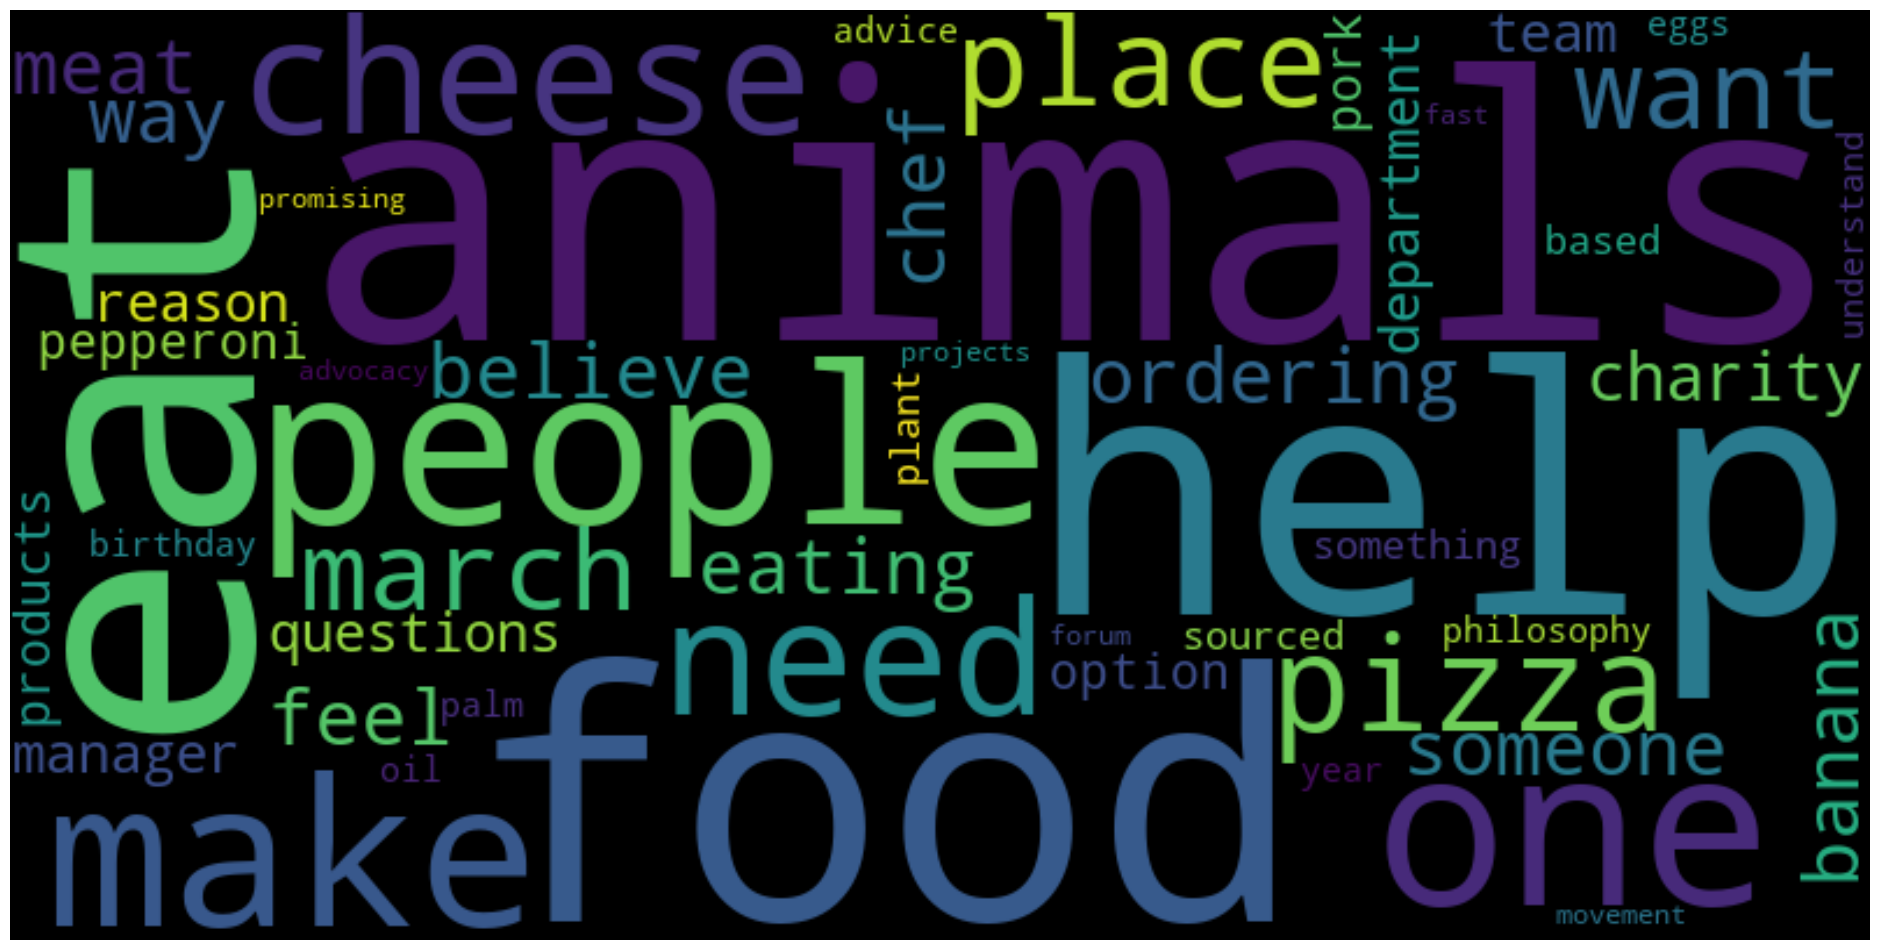

In [68]:
# Using the WordCloud library to create a wordcloud from the dict
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(clean_dictionary)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
wc.to_file("Vegan WordCloud.png")
# plt.show()

In [67]:
# Saving the image to local folder
wc.to_file("Vegan WordCloud.png")